In [1]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import glob, os
from random import shuffle
from utils.vis import showImageMask, overlayPlot

import yaml
import math
import numpy as np
import torch
torch.backends.cudnn.benchmark = True
import torch.nn as nn

from data.dataset import SegmentDataset
from data.transforms import transform
from data.collate import collate
from torch.utils.data import DataLoader
from models.model import SegmentModel
from models.unet import UNet
from models.utils.loss import PixelLoss
from metrics.metrics import pixelAccuracy, gatherMetrics
from metrics.pred import predict, getMask
from utils.vis import showPredictions
from utils.decorators import timer
from utils.parameters import *
from metrics.metrics import bakeWeight
from metrics.utils import conf_operations

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def getRandomImages(max_=10, src="/content/data/**/*_image.png"):
    images = glob.glob(src)
    shuffle(images)
    images = images[:max_]
    masks = [img.replace('_image.png', '_labels.png') for img in images]
    return images, masks
    
images, masks = getRandomImages(10)

In [4]:
version = 'street_v5'
cfg_path = '../configs/{}.yml'.format(version.replace('_', '/').replace('-', '/'))
all_configs = yaml.safe_load(open(cfg_path))

random_seed = int(all_configs['random_seed'])
batch_size = int(all_configs['batch_size'])
num_classes = int(all_configs['num_classes'])
if num_classes==2:
    ftr = all_configs['ftr']
    if ftr.lower()=='street':
        index2name = index2name_street
        color2index = color2index_street
    elif ftr.lower()=='building':
        index2name = index2name_building
        color2index = color2index_building
    else:
        raise ValueError("Unknown feature found - {}".format(ftr))

train_annot = '../'+all_configs['train_annot']
val_annot = '../'+all_configs['val_annot']

H = all_configs['H'] if 'H' in all_configs else 2048
W = all_configs['W'] if 'W' in all_configs else 2048

CHCEKPOINT_DIR = '../'+all_configs['CHCEKPOINT_DIR']
ckpt_dir = os.path.join(CHCEKPOINT_DIR, version)

In [5]:
os.listdir(ckpt_dir)

['best_41.pth', 'latest_47.pth']

In [6]:
model = UNet(n_channels=3, n_classes=num_classes).cuda()
model.load_state_dict(torch.load(os.path.join(ckpt_dir, 'best_41.pth')))

<All keys matched successfully>

In [7]:
val_set = SegmentDataset(
    annot=val_annot, 
    transform=transform, 
    dim=(H, W), 
    c2i=color2index
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    num_workers=8,
    collate_fn=collate,
)

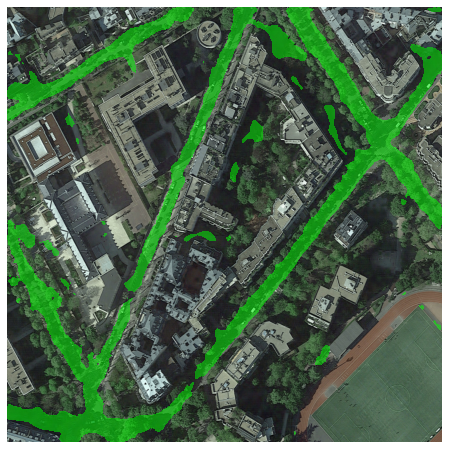

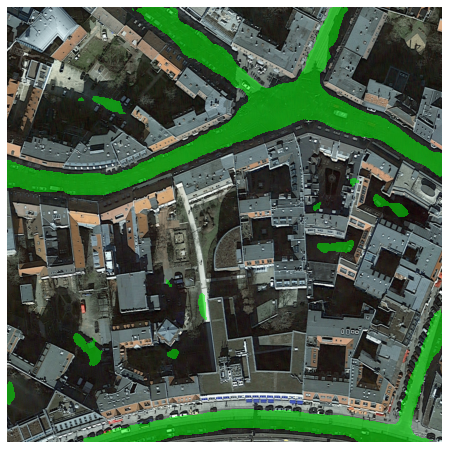

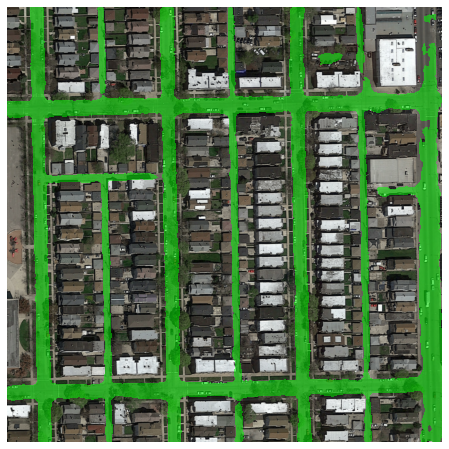

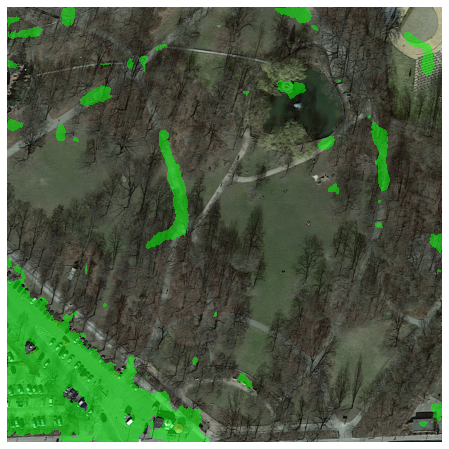

In [ ]:
from utils.parameters import COLORS_OVERLAY

thres = 'auto'
for batch_idx, (_, _, image, mask) in enumerate(val_loader):
    y_pred = model(image.cuda())
    y_pred = torch.nn.Softmax(dim=1)(y_pred)
    mask_pred = predict(None, None, use_cache=True, params=(y_pred.detach().cpu(), True), thres=thres).squeeze().numpy()
    # print(mask_pred.shape)
    
    img = image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    overlayPlot(img, mask_pred, use_path=False, debug=True, size=(8, 8), transparency=0.5)
    
    if batch_idx==5:
        break